# Movie Recommendations
## CapStone 8
### EDA

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.cluster import FeatureAgglomeration
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

Converting txt to csv file as it provides a standard, easily parsed format for analysis.

In [262]:
dataMovies = pd.read_csv('movies.txt')
dataMovies.to_csv('dataMovies.csv', index=False)
dataRatings = pd.read_csv('ratings.txt')
dataRatings.to_csv('dataRatings.csv', index=False)

In [263]:
print("Display Data head:")
print(dataMovies.head())
dfMovies = pd.DataFrame(dataMovies)

Display Data head:
   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  


In [264]:
print("Display Data head:")
print(dataRatings.head())
dfRatings = pd.DataFrame(dataRatings)

Display Data head:
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


In [265]:
dfMovies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [266]:
dfRatings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


| Column Name | Type        | Subtype                 | Notes                                                                                                                         |
| ----------- | ----------- | ----------------------- | ----------------------------------------------------------------------------------------------------------------------------- |
| `userId`    | Categorical | Nominal (Discrete ID)   | Unique identifier for a user.         |
| `movieId`   | Categorical | Nominal (Discrete ID)   | Unique identifier for a movie.
| `rating`    | Numerical   | Ordinal / Discrete      | User’s rating of a movie.
| `timestamp` | Numerical   | Continuous (Time-based) | timestamp representing when the rating was given.

| Column Name | Type        | Subtype               | Notes                              |
|-------------|-------------|------------------------|--------------------------------------|
| `movieId`   | Categorical | Nominal (Discrete ID) | Unique movie identifier.             |
| `title`     | Categorical | Nominal               | Movie title                          |
| `genres`    | Categorical | Nominal (Multi-label) | Pipe-separated list of genres        |

Together looking at the dataset at a high level we can tell the Movies and Ratings datasets form a user item interaction dataset, which is used for recommendation systems and behavior analysis rather than traditional prediction problems.</br>
Instantly you can tell there's a lot you can do with this dataset, starting with organizing the genres, and checking ratings and seeing which genre is the best, and much much more.

In [267]:
dfMovies.isna().sum()


movieId    0
title      0
genres     0
dtype: int64

In [268]:
dfRatings.isna().sum()

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64

Good thing there's no null values to deal with here.</br>
Since timestamp has values we can utilize and get deeper into our EDA I have decided to expand the timestamp for more thorough analysis, early on.

In [269]:
dfRatings["timestamp"] = pd.to_datetime(dfRatings["timestamp"], unit="s")
dfRatings["timestampYear"] = dfRatings["timestamp"].dt.year
dfRatings["timestampMonth"] = dfRatings["timestamp"].dt.month
dfRatings["timestampDay"] = dfRatings["timestamp"].dt.day
dfRatings["timestampDayOfWeek"] = dfRatings["timestamp"].dt.dayofweek
dfRatings["timestampHour"] = dfRatings["timestamp"].dt.hour
dfRatings["timestampDayName"] = dfRatings["timestamp"].dt.day_name()
dfRatings.head()

,userId,movieId,rating,timestamp,timestampYear,timestampMonth,timestampDay,timestampDayOfWeek,timestampHour,timestampDayName
0,1,1,4.0,2000-07-30 18:45:03,2000,7,30,6,18,Sunday
1,1,3,4.0,2000-07-30 18:20:47,2000,7,30,6,18,Sunday
2,1,6,4.0,2000-07-30 18:37:04,2000,7,30,6,18,Sunday
3,1,47,5.0,2000-07-30 19:03:35,2000,7,30,6,19,Sunday
4,1,50,5.0,2000-07-30 18:48:51,2000,7,30,6,18,Sunday


#### Rating Distribution

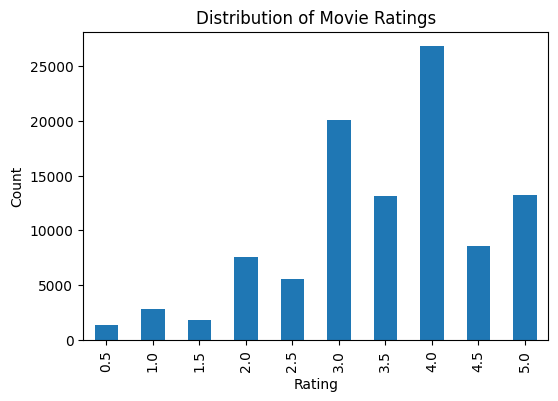

In [270]:
plt.figure(figsize=(6,4))
dfRatings["rating"].value_counts().sort_index().plot(kind="bar")
plt.title("Distribution of Movie Ratings")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()


The rating distribution is positively skewed, with most ratings concentrated between 3.0 and 5.0. This indicates a positivity bias, where users are more likely to rate movies they enjoyed. Low ratings are relatively rare, suggesting selective user engagement rather than neutral. Which is totally understandable.

#### Ratings Over Time

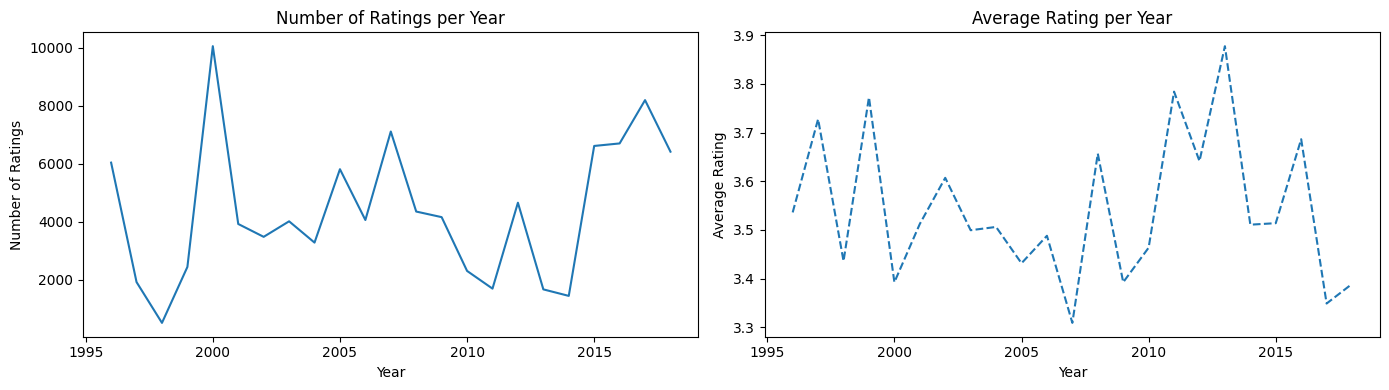

In [271]:
ratings_per_year = dfRatings.groupby("timestampYear").size()
avg_rating_year = dfRatings.groupby("timestampYear")["rating"].mean()

fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharex=True)

# Plot 1: Number of Ratings per Year
axes[0].plot(ratings_per_year)
axes[0].set_title("Number of Ratings per Year")
axes[0].set_xlabel("Year")
axes[0].set_ylabel("Number of Ratings")

# Plot 2: Average Rating per Year
axes[1].plot(avg_rating_year, linestyle="--")
axes[1].set_title("Average Rating per Year")
axes[1].set_xlabel("Year")
axes[1].set_ylabel("Average Rating")

plt.tight_layout()
plt.show()


The number of ratings varies significantly by year, showing sharp spikes and declines rather than a steady trend. An early surge around 2000 is followed by a period of reduced activity, with a notable recovery after 2014. This suggests fluctuating user engagement over time, could possible be influenced by platform growth and data collection patterns.

#### Day of Week Behavior

In [272]:
ordered_days = [
    "Monday", "Tuesday", "Wednesday",
    "Thursday", "Friday", "Saturday", "Sunday"
]

dayname_counts = (
    dfRatings["timestampDayName"]
    .value_counts()
    .reindex(ordered_days)
)

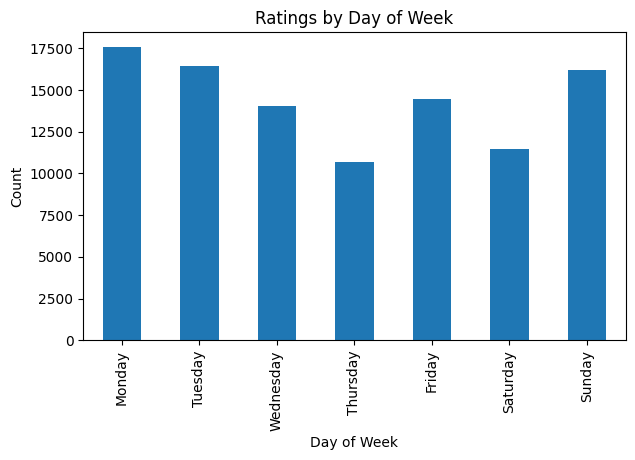

In [273]:

plt.figure(figsize=(7,4))
dayname_counts.plot(kind="bar")
plt.title("Ratings by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Count")
plt.show()


In order from highest to lowest.

#### Hourly Activity Pattern

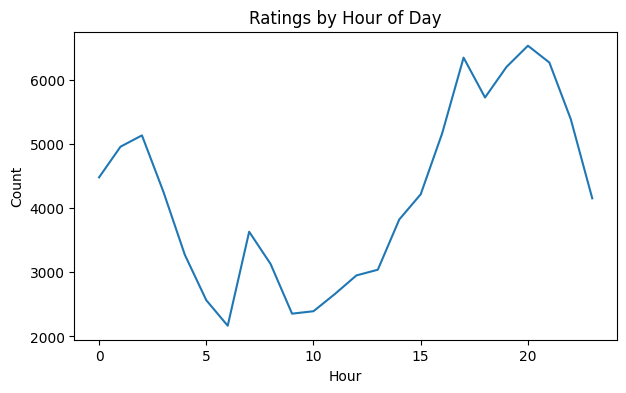

In [274]:
hour_counts = dfRatings.groupby("timestampHour").size()

plt.figure(figsize=(7,4))
hour_counts.plot()
plt.title("Ratings by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()


Ratings were usually made on the third quarter of the day, obviously after work hours.

#### Ratings vs Time (Behvaioral Depth) / User Activity Patterns

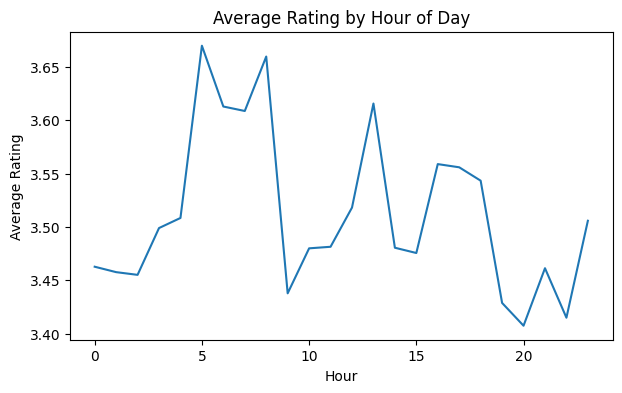

In [275]:
avg_rating_hour = dfRatings.groupby("timestampHour")["rating"].mean()

plt.figure(figsize=(7,4))
avg_rating_hour.plot()
plt.title("Average Rating by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Average Rating")
plt.show()


Average ratings remain relatively stable throughout the day, with only minor fluctuations. Slightly higher ratings appear in the early morning and midday hours, while late evening ratings tend to be marginally lower. Overall, time of day has a `limited impact` on rating sentiment.


#### Genre-based insights

In [276]:
dfMerged = dfRatings.merge(dfMovies, on="movieId", how="left")


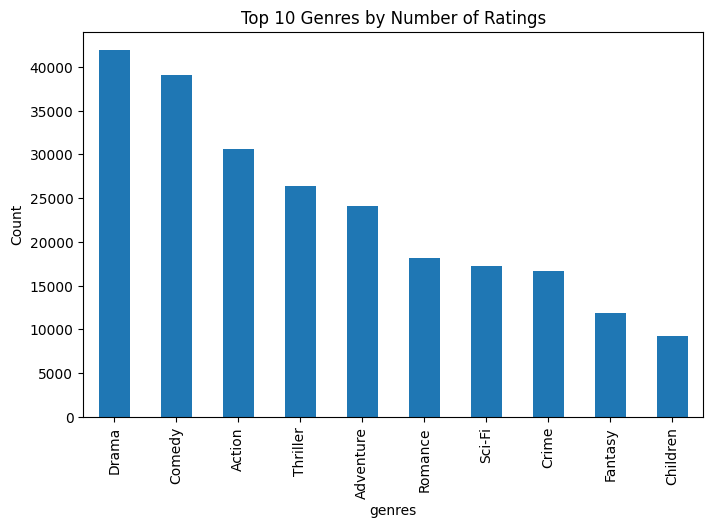

In [277]:
genre_counts = (
    dfMerged["genres"]
    .str.split("|")
    .explode()
    .value_counts()
)

plt.figure(figsize=(8,5))
genre_counts.head(10).plot(kind="bar")
plt.title("Top 10 Genres by Number of Ratings")
plt.ylabel("Count")
plt.show()


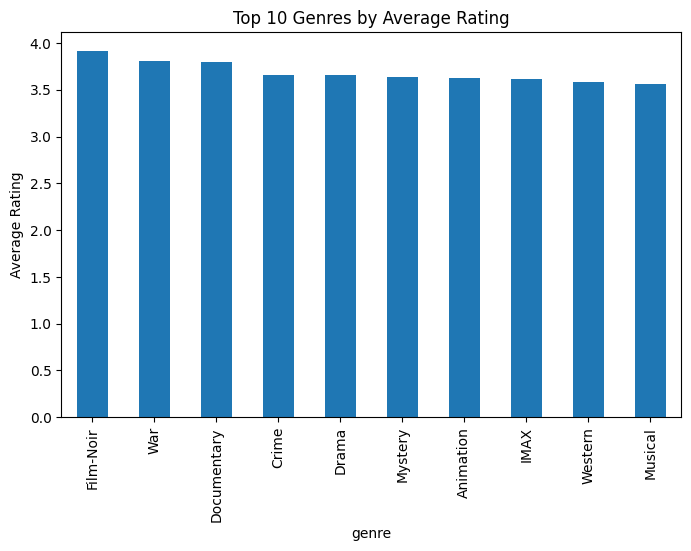

In [278]:
avg_genre_rating = (
    dfMerged.assign(genre=dfMerged["genres"].str.split("|"))
    .explode("genre")
    .groupby("genre")["rating"]
    .mean()
    .sort_values(ascending=False)
)

plt.figure(figsize=(8,5))
avg_genre_rating.head(10).plot(kind="bar")
plt.title("Top 10 Genres by Average Rating")
plt.ylabel("Average Rating")
plt.show()


### Data Wrangling

Since I have already checked for missing data, and null values in EDA let's look into outliers.
#### Outliers

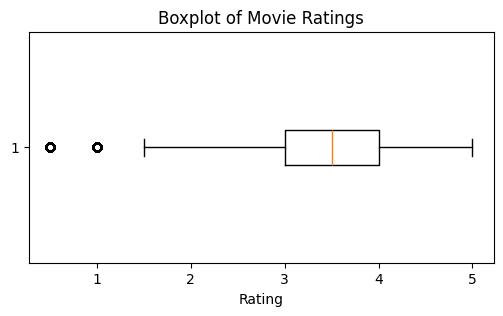

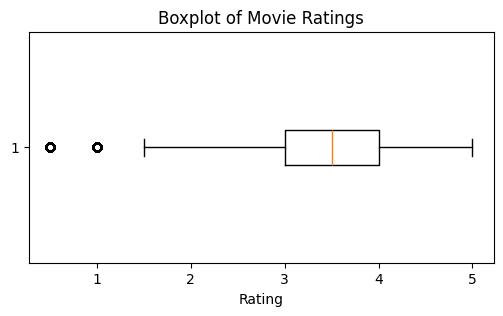

In [279]:
plt.figure(figsize=(6,3))
plt.boxplot(dfRatings["rating"], vert=False)
plt.title("Boxplot of Movie Ratings")
plt.xlabel("Rating")
plt.show()
plt.figure(figsize=(6,3))
plt.boxplot(dfRatings["rating"], vert=False)
plt.title("Boxplot of Movie Ratings")
plt.xlabel("Rating")
plt.show()

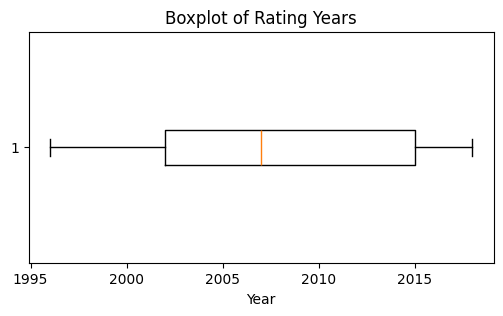

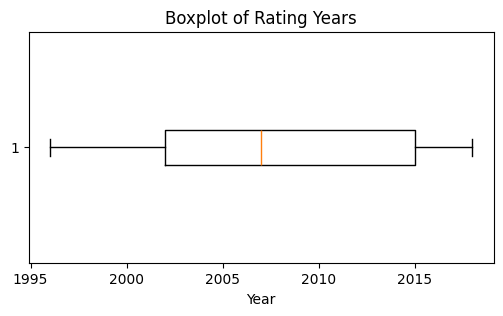

In [280]:
plt.figure(figsize=(6,3))
plt.boxplot(dfRatings["timestampYear"], vert=False)
plt.title("Boxplot of Rating Years")
plt.xlabel("Year")
plt.show()
plt.figure(figsize=(6,3))
plt.boxplot(dfRatings["timestampYear"], vert=False)
plt.title("Boxplot of Rating Years")
plt.xlabel("Year")
plt.show()


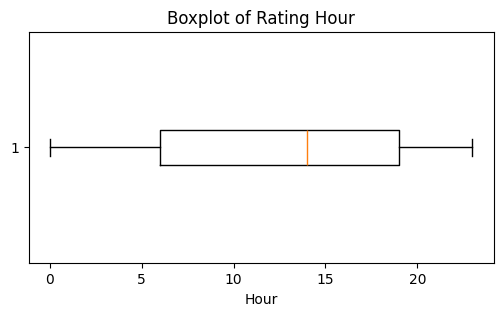

In [281]:
plt.figure(figsize=(6,3))
plt.boxplot(dfRatings["timestampHour"], vert=False)
plt.title("Boxplot of Rating Hour")
plt.xlabel("Hour")
plt.show()


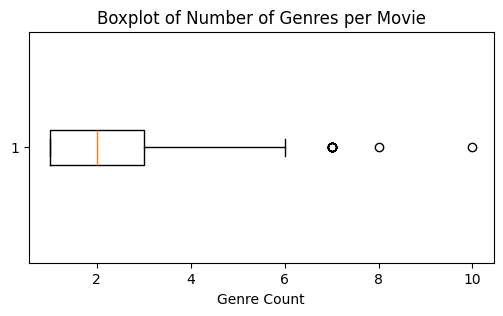

In [282]:
dfMovies["genreCount"] = dfMovies["genres"].str.split("|").apply(len)
plt.figure(figsize=(6,3))
plt.boxplot(dfMovies["genreCount"], vert=False)
plt.title("Boxplot of Number of Genres per Movie")
plt.xlabel("Genre Count")
plt.show()


No true numerical outliers were identified in the ratings dataset. Rating values and time-based features are naturally bounded, and extreme values represent valid user behavior rather than data errors.

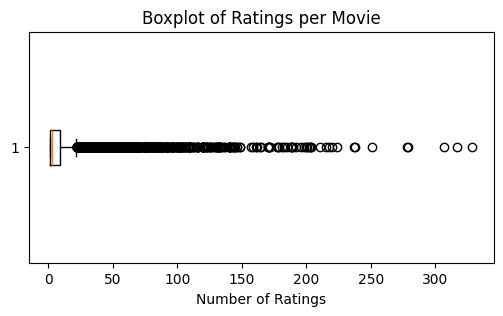

In [283]:
ratings_per_movie = dfRatings.groupby("movieId").size()

plt.figure(figsize=(6,3))
plt.boxplot(ratings_per_movie, vert=False)
plt.title("Boxplot of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.show()


Outlier analysis revealed no true numerical anomalies in the ratings dataset, as values are naturally bounded and represent valid user behavior. In the movies dataset, variation in genre counts and ratings per movie reflects structural and popularity-based skew rather than data errors. These patterns are characteristic of realistic data.

#### Feature Engineering

##### Genre Featuring
Merging Ratings with Movies

In [284]:
dfRatingsWithGenres = dfRatings.merge(
    dfMovies[["movieId", "genres"]],
    on="movieId",
    how="left"
)
dfRatingsWithGenres["genres"].head()


0    Adventure|Animation|Children|Comedy|Fantasy
1                                 Comedy|Romance
2                          Action|Crime|Thriller
3                               Mystery|Thriller
4                         Crime|Mystery|Thriller
Name: genres, dtype: object

Splitting Genres into Lists

In [285]:
dfRatingsWithGenres["genreList"] = (
    dfRatingsWithGenres["genres"]
    .str.split("|")
)
dfRatingsWithGenres["genreList"].head()

0    [Adventure, Animation, Children, Comedy, Fantasy]
1                                    [Comedy, Romance]
2                            [Action, Crime, Thriller]
3                                  [Mystery, Thriller]
4                           [Crime, Mystery, Thriller]
Name: genreList, dtype: object

Hot Encoding Genres to create binary genre features

In [286]:
mlb = MultiLabelBinarizer()

genre_encoded = pd.DataFrame(
    mlb.fit_transform(dfRatingsWithGenres["genreList"]),
    columns=mlb.classes_,
    index=dfRatingsWithGenres.index
)


Creating Separate dataframe for feature engineering to keep things aligned

In [287]:
dfRatingsFE = pd.concat(
    [dfRatingsWithGenres.drop(columns=["genres", "genreList"]), genre_encoded],
    axis=1
)
dfRatingsFE.head()

,userId,movieId,rating,timestamp,timestampYear,timestampMonth,timestampDay,timestampDayOfWeek,timestampHour,timestampDayName,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000-07-30 18:45:03,2000,7,30,6,18,Sunday,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,2000-07-30 18:20:47,2000,7,30,6,18,Sunday,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,2000-07-30 18:37:04,2000,7,30,6,18,Sunday,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,2000-07-30 19:03:35,2000,7,30,6,19,Sunday,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,2000-07-30 18:48:51,2000,7,30,6,18,Sunday,...,0,0,0,0,1,0,0,1,0,0


Genre information was merged into the ratings dataset and transformed using multi-label one-hot encoding. This allowed each rating to be represented by a set of binary genre features, enabling genre-aware analysis and modeling.

In [288]:
dfMoviesFE = dfMovies.copy()

# Split genres
dfMoviesFE["genreList"] = dfMoviesFE["genres"].str.split("|")

# One-hot encode genres
mlb = MultiLabelBinarizer()

genre_encoded = pd.DataFrame(
    mlb.fit_transform(dfMoviesFE["genreList"]),
    columns=mlb.classes_,
    index=dfMoviesFE.index
)

# Combine
dfMoviesFE = pd.concat(
    [dfMoviesFE.drop(columns=["genres", "genreList"]), genre_encoded],
    axis=1
)
dfRatingsFE = dfRatings.copy()
Merged_df = dfRatingsFE.merge(
    dfMoviesFE,
    on="movieId",
    how="left"
)



In [289]:
Merged_df.shape
Merged_df.isnull().sum().head()
Merged_df.head()

,userId,movieId,rating,timestamp,timestampYear,timestampMonth,timestampDay,timestampDayOfWeek,timestampHour,timestampDayName,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,1,4.0,2000-07-30 18:45:03,2000,7,30,6,18,Sunday,...,0,0,0,0,0,0,0,0,0,0
1,1,3,4.0,2000-07-30 18:20:47,2000,7,30,6,18,Sunday,...,0,0,0,0,0,1,0,0,0,0
2,1,6,4.0,2000-07-30 18:37:04,2000,7,30,6,18,Sunday,...,0,0,0,0,0,0,0,1,0,0
3,1,47,5.0,2000-07-30 19:03:35,2000,7,30,6,19,Sunday,...,0,0,0,0,1,0,0,1,0,0
4,1,50,5.0,2000-07-30 18:48:51,2000,7,30,6,18,Sunday,...,0,0,0,0,1,0,0,1,0,0


Feature engineering was performed separately on the movies and ratings datasets to maintain modularity and clarity. The engineered datasets were then merged on `movieId` to create a unified feature set `Merged_df` for modeling user–movie interactions.

Creating a new DataFrame for UI_Matrix_df

In [290]:
dfRatingsWithTitles = dfRatings.merge(
    dfMovies[["movieId", "title"]],
    on="movieId",
    how="left"
)
Ul_Matrix_df = dfRatingsWithTitles.pivot_table(
    index="userId",
    columns="title",
    values="rating"
)
Ul_Matrix_df.shape
Ul_Matrix_df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we have a separate dataframe to check for which userId rated which movie and the rating value of the movie.

#### Fill Row-wise NaNs

In [291]:
Ul_filled = Ul_Matrix_df.apply(
    lambda row: row.fillna(row.mean()),
    axis=1
)


To enable similarity calculations, missing ratings were populated on each user basis using the user’s average rating. This preserves individual rating behavior and prevents bias introduced by global averages.

#### User to User Cosine Similarity

In [292]:
cosine_sim = cosine_similarity(Ul_filled)

UserUser_Cosine = pd.DataFrame(
    cosine_sim,
    index=Ul_filled.index,
    columns=Ul_filled.index
)


Cosine similarity was computed using the filled user–item matrix to measure how similar users are based on the direction of their rating patterns. This approach captures similarity in preferences regardless of absolute rating scale.

#### User to User Pearson Similarity

In [293]:
UserUser_Pearson = Ul_Matrix_df.T.corr(method="pearson")


Pearson correlation was computed directly on the original user–item matrix to measure similarity based on how users deviate from their own average ratings. This method emphasizes relative preference patterns and accounts for user bias.

Updated Prediction Function which uses Ul_Matrix_df

In [294]:
def predict_rating_user_user(
    UID,
    MID,
    Ul_matrix,
    similarityMatrix,
    k=50
):
    if MID not in Ul_matrix.columns:
        return np.nan

    simScores = similarityMatrix.loc[UID].drop(UID)

    movieRatings = Ul_matrix[MID].dropna()
    simScores = simScores.loc[movieRatings.index]

    top_k = simScores.sort_values(ascending=False).head(k)

    if top_k.empty:
        return np.nan

    ratings = movieRatings.loc[top_k.index]

    predictedRating = np.dot(top_k, ratings) / np.sum(np.abs(top_k))

    return predictedRating


- Ranking all users by similarity to the target user
- Selecting the top-k most similar users who have rated the movie
- Computing a weighted average of their ratings using similarity scores as weights

#### Testing

In [295]:
movie_title_32 = dfMovies.loc[dfMovies["movieId"] == 32, "title"].values[0]

predCosine = predict_rating_user_user(
    UID=1,
    MID=movie_title_32,
    Ul_matrix=Ul_Matrix_df,
    similarityMatrix=UserUser_Cosine,
    k=50
)

predPearson = predict_rating_user_user(
    UID=1,
    MID=movie_title_32,
    Ul_matrix=Ul_Matrix_df,
    similarityMatrix=UserUser_Pearson,
    k=50
)

predCosine, predPearson


(np.float64(4.08999370401491), np.float64(4.077198413747881))

The predicted rating for User 1 on Movie 32 is around 4.0 using both cosine and Pearson similarity, indicating a high likelihood that the user would enjoy the movie.

User–user collaborative filtering predicts ratings based on shared user behavior, with cosine similarity measuring overall preference alignment and Pearson correlation capturing relative rating patterns.

#### Item to Item Similarity Matrices

Fill column wise NaNs using each movie's average rating

In [296]:
Ul_item_filled = Ul_Matrix_df.apply(
    lambda col: col.fillna(col.mean()),
    axis=0
)

Item to Item Cosine Similarity Matrix </br>
Compute cosine similarity across movie columns, so we transpose

In [297]:
item_cosine_sim = cosine_similarity(Ul_item_filled.T)

ItemItem_Cosine = pd.DataFrame(
    item_cosine_sim,
    index=Ul_item_filled.columns,
    columns=Ul_item_filled.columns
)

Item to Item Pearson Similarity

In [298]:
ItemItem_Pearson = Ul_Matrix_df.corr(method="pearson")


##### Top-N most Similar Movies to MovieID (MID)

In [299]:
def movieid_to_title(mid, dfMovies):
    matches = dfMovies.loc[dfMovies["movieId"] == mid, "title"].values
    return matches[0] if len(matches) else None

Top-N Similar Movies Function

In [300]:
def top_n_similar_movies(
    MID,
    similarityMatrix,
    dfMovies,
    N=10
):
    target_title = movieid_to_title(MID, dfMovies)
    if target_title is None:
        raise ValueError(f"movieId {MID} not found in dfMovies.")

    if target_title not in similarityMatrix.index:
        raise ValueError(
            f"Title '{target_title}' not found in the Item-Item similarity matrix. "
            "This can happen if titles were not used consistently in Ul_Matrix_df."
        )

    sims = similarityMatrix.loc[target_title].drop(labels=[target_title])
    topN = sims.sort_values(ascending=False).head(N)

    return topN  # returns a Series: index=title, value=similarity


##### Testing Most Similar Movies to Jurassic Park (1993)

In [ ]:
jp_mid = dfMovies.loc[dfMovies["title"] == "Jurassic Park (1993)", "movieId"].values[0]
jp_mid

np.int64(480)

In [ ]:
top10_cosine = top_n_similar_movies(
    MID=jp_mid,
    similarityMatrix=ItemItem_Cosine,
    dfMovies=dfMovies,
    N=10
)

top10_cosine

title
Lethal Weapon (1987)              0.990697
The Lego Batman Movie (2017)      0.990542
Mr. Bean's Holiday (2007)         0.990508
Mulan (1998)                      0.990426
Incredible Journey, The (1963)    0.990418
High Plains Drifter (1973)        0.990417
Kramer vs. Kramer (1979)          0.990417
La La Land (2016)                 0.990365
Awakenings (1990)                 0.990364
Sully (2016)                      0.990357
Name: Jurassic Park (1993), dtype: float64

In [ ]:
top10_pearson = top_n_similar_movies(
    MID=jp_mid,
    similarityMatrix=ItemItem_Pearson,
    dfMovies=dfMovies,
    N=10
)

top10_pearson

title
School Daze (1988)                                              1.0
Haywire (2011)                                                  1.0
Mr. Death: The Rise and Fall of Fred A. Leuchter, Jr. (1999)    1.0
Mr. & Mrs. Smith (1941)                                         1.0
Land Before Time III: The Time of the Great Giving (1995)       1.0
Greenberg (2010)                                                1.0
Mother Night (1996)                                             1.0
From Justin to Kelly (2003)                                     1.0
Dog Soldiers (2002)                                             1.0
Book of Shadows: Blair Witch 2 (2000)                           1.0
Name: Jurassic Park (1993), dtype: float64

In [ ]:
pd.DataFrame({
    "CosineSimilarity": top10_cosine,
    "PearsonSimilarity": top10_pearson
}).sort_values(by="CosineSimilarity", ascending=False)

,CosineSimilarity,PearsonSimilarity
title,,
Lethal Weapon (1987),0.990697,NaN
The Lego Batman Movie (2017),0.990542,NaN
Mr. Bean's Holiday (2007),0.990508,NaN
Mulan (1998),0.990426,NaN
"Incredible Journey, The (1963)",0.990418,NaN
High Plains Drifter (1973),0.990417,NaN
Kramer vs. Kramer (1979),0.990417,NaN
La La Land (2016),0.990365,NaN
Awakenings (1990),0.990364,NaN


### Item–Item Collaborative Filtering

Item-based collaborative filtering was implemented by treating each movie as a vector of user ratings. Missing ratings were filled column-wise using each movie’s mean rating. Item–item similarity was computed using both cosine similarity and Pearson correlation. A function was created to rank and return the top-N most similar movies to a given movieId, and it was tested using *Jurassic Park (1993)* as the reference movie.
### Item–Item Collaborative Filtering

Item-based collaborative filtering was implemented by treating each movie as a vector of user ratings. Missing ratings were filled column-wise using each movie’s mean rating. Item–item similarity was computed using both cosine similarity and Pearson correlation. A function was created to rank and return the top-N most similar movies to a given movieId, and it was tested using *Jurassic Park (1993)* as the reference movie.